In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

In [8]:
# 1) Cargar datos
datos = pd.read_csv(filepath_or_buffer="C:/Users/jenif/Downloads/breast-cancer.csv")

In [9]:
datos

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [10]:
# 2) Configurar TARGET y limpieza mínima
TARGET_COLUMN = "diagnosis"
y_raw = datos[TARGET_COLUMN]
X = datos.drop(columns=[TARGET_COLUMN, "id"], errors="ignore")  # eliminamos 'id' si existe


In [11]:
# Convertir clase M/B a 1/0
mapping = {"M": 1, "B": 0}
y = y_raw.map(mapping)


In [12]:
# 3) Escalado 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
# 5) Modelo base: Random Forest
rf = RandomForestClassifier(random_state=42)

In [19]:
# 6) Hiperparámetros para búsqueda aleatoria
param_distributions = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"]  # 'auto' reemplazado por None
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [20]:
# 7) Ajuste del modelo
rs.fit(X_train, y_train)
best_model = rs.best_estimator_
print("\nMejor AUC-ROC (CV):", rs.best_score_)
print("Mejores hiperparámetros:", rs.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejor AUC-ROC (CV): 0.9882352941176471
Mejores hiperparámetros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}


In [21]:
# 8) Evaluación en test
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

print("\n=== Métricas en Test ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1       : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")


=== Métricas en Test ===
Accuracy : 0.9737
Precision: 1.0000
Recall   : 0.9286
F1       : 0.9630
ROC-AUC  : 0.9950


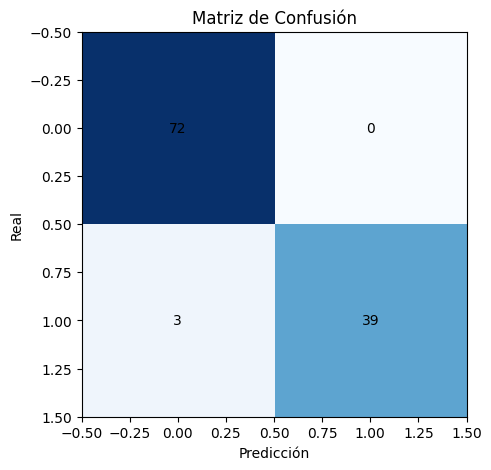

In [22]:
# 9) Gráficas
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción"); plt.ylabel("Real")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.show()

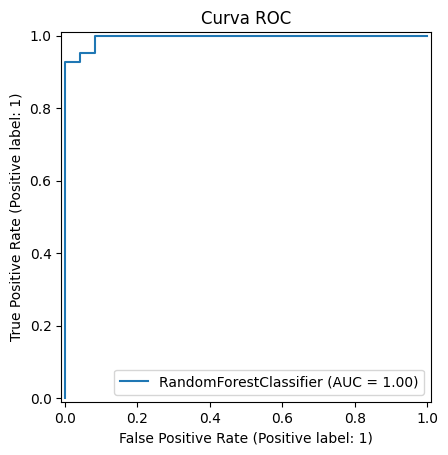

In [23]:

# Curva ROC
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva ROC")
plt.show()


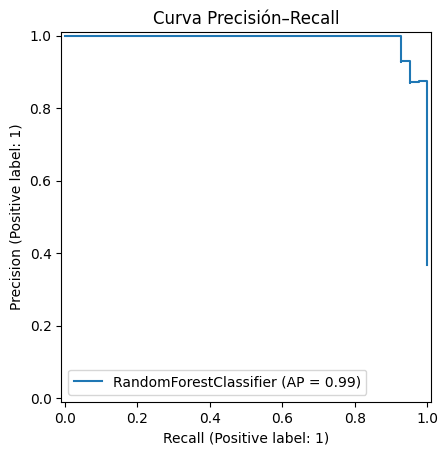

In [24]:
# Curva Precisión-Recall
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva Precisión–Recall")
plt.show()

In [25]:

# 10) Importancia de variables
feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)
print("\nTop 10 variables por importancia:")
display(feat_importances.head(10))



Top 10 variables por importancia:


area_worst              0.152915
concave points_worst    0.134546
radius_worst            0.100371
perimeter_worst         0.087629
concave points_mean     0.083709
perimeter_mean          0.077532
radius_mean             0.059437
concavity_mean          0.051643
area_mean               0.044947
concavity_worst         0.030722
dtype: float64

In [27]:

# 11) Guardar modelo
os.makedirs("model", exist_ok=True)
joblib.dump(best_model, "model/rf_breast_cancer.pkl")
print("Modelo guardado en carpeta" )

Modelo guardado en carpeta
